In [53]:
! pip install pandas

In [54]:
! pip install tensorflow-gpu

In [55]:
!pip install keras

In [56]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
GPU is available


In [57]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [58]:
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [60]:
IMAGE_SIZE = [224, 224]

train_data = '/content/drive/My Drive/Colab Notebooks/Flowers'

In [61]:
vgg=VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [62]:
for layer in vgg.layers:
        layer.trainable = False


In [63]:
# useful for getting number of output classes
folders = glob('/content/drive/My Drive/Colab Notebooks/Flowers/*')
len(folders)

5

In [64]:
# our layers - you can add more if you want

x = Flatten()(vgg.output)

In [65]:
prediction=Dense(len(folders), activation='softmax')(x)


In [66]:
model = Model(inputs=vgg.input, outputs=prediction)

In [67]:

# view the structure of the model
model.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [68]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)



In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip = True,
    rotation_range=20,
    shear_range=0.05,
    zoom_range=0.2,
    validation_split=0.2
    #channel_shift_range=0.1
)

In [70]:

# Make sure you provide the same target size as initialied for the image size
training_set = image_datagen.flow_from_directory(train_data,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True, 
                                                 seed=42,
                                                 subset="training")


Found 3462 images belonging to 5 classes.


In [71]:
test_set = image_datagen.flow_from_directory(train_data,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                             shuffle=True, 
                                              seed=42,
                                             subset="validation")

Found 861 images belonging to 5 classes.


In [72]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=25,
  shuffle=True,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/25
109/109 [==============================] - 59s 537ms/step - loss: 1.1078 - accuracy: 0.6138 - val_loss: 0.8527 - val_accuracy: 0.7027
Epoch 2/25
109/109 [==============================] - 58s 536ms/step - loss: 0.6302 - accuracy: 0.7753 - val_loss: 0.6133 - val_accuracy: 0.7793
Epoch 3/25
109/109 [==============================] - 58s 533ms/step - loss: 0.5414 - accuracy: 0.8108 - val_loss: 0.6232 - val_accuracy: 0.7747
Epoch 4/25
109/109 [==============================] - 58s 535ms/step - loss: 0.4882 - accuracy: 0.8244 - val_loss: 0.6741 - val_accuracy: 0.7758
Epoch 5/25
109/109 [==============================] - 58s 534ms/step - loss: 0.4556 - accuracy: 0.8310 - val_loss: 0.5658 - val_accuracy: 0.8200
Epoch 6/25
109/109 [==============================] - 58s 530ms/step - loss: 0.3709 - accuracy: 0.8692 - val_loss: 0.6451 - val_accuracy: 0.7851
Epoch 7/25
109/109 [==============================] - 58s 534ms/step - loss: 0.3544 - accuracy: 0.8718 - val_loss: 0.5753 - val_ac

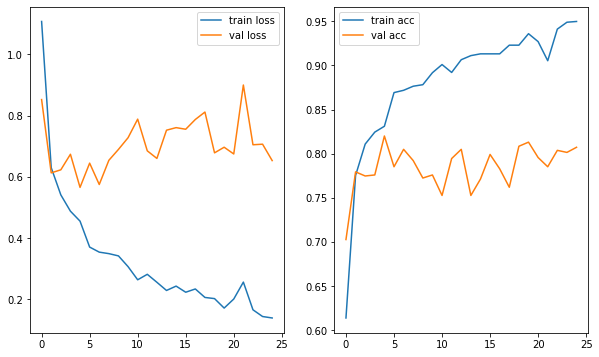

In [73]:
# plot the loss
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.subplot(1,2,2)
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('AccVal_acc')

In [74]:
k=r.history['val_accuracy']
np.array(k[-1])

array(0.80720091)

In [75]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('Flowers_model_vgg19.h5')

In [76]:
y_pred = model.predict(test_set)

In [77]:
y_pred

array([[6.29095081e-03, 1.44884884e-01, 2.24388111e-03, 5.78159273e-01,
        2.68421024e-01],
       [2.35006664e-05, 1.38205469e-05, 9.97702181e-01, 8.89778130e-06,
        2.25160713e-03],
       [1.99980278e-07, 4.83795645e-07, 1.32340153e-06, 9.99997973e-01,
        3.30101706e-08],
       ...,
       [1.20076336e-04, 1.05472748e-06, 8.85800036e-15, 9.99878883e-01,
        1.10780329e-09],
       [7.61010405e-03, 2.98992242e-03, 4.80168354e-04, 5.81042022e-02,
        9.30815637e-01],
       [9.82829034e-01, 1.67145319e-02, 2.91368138e-04, 8.90728825e-06,
        1.56169321e-04]], dtype=float32)

In [78]:

import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [79]:
y_pred

array([3, 2, 3, 2, 1, 1, 3, 2, 1, 2, 0, 0, 1, 1, 1, 2, 1, 4, 0, 4, 0, 4,
       4, 2, 4, 0, 2, 1, 4, 1, 4, 0, 1, 2, 2, 4, 3, 3, 2, 4, 4, 0, 0, 1,
       2, 0, 1, 4, 0, 1, 1, 0, 4, 1, 1, 0, 0, 1, 2, 1, 4, 4, 0, 4, 1, 1,
       0, 1, 3, 4, 4, 1, 4, 0, 3, 4, 4, 2, 4, 1, 3, 4, 4, 4, 0, 3, 0, 4,
       3, 2, 2, 3, 0, 3, 2, 0, 2, 1, 4, 0, 4, 0, 4, 4, 4, 0, 3, 3, 0, 2,
       2, 2, 0, 3, 2, 1, 0, 0, 2, 2, 1, 0, 1, 0, 3, 1, 4, 3, 3, 4, 1, 2,
       1, 1, 1, 0, 1, 3, 4, 2, 0, 3, 2, 0, 4, 3, 0, 1, 4, 2, 0, 4, 1, 1,
       4, 4, 0, 1, 2, 0, 1, 2, 3, 0, 0, 2, 1, 1, 0, 4, 2, 3, 4, 3, 1, 2,
       2, 0, 0, 4, 0, 4, 0, 2, 1, 1, 3, 3, 4, 2, 0, 3, 4, 3, 0, 0, 0, 4,
       1, 1, 0, 0, 0, 4, 2, 2, 4, 4, 2, 1, 0, 3, 2, 4, 1, 0, 0, 0, 3, 0,
       2, 4, 4, 1, 0, 0, 2, 1, 3, 1, 1, 0, 4, 0, 1, 1, 4, 3, 1, 3, 1, 4,
       0, 3, 4, 0, 1, 1, 4, 1, 0, 3, 2, 0, 0, 1, 0, 0, 3, 3, 0, 1, 0, 4,
       1, 0, 2, 2, 4, 0, 2, 4, 4, 4, 2, 4, 0, 3, 4, 1, 1, 4, 3, 0, 1, 4,
       1, 1, 0, 0, 3, 3, 4, 4, 1, 1, 1, 1, 0, 1, 3,

In [80]:
np.array(y_pred==0).sum()

183

In [81]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [82]:
model=load_model('Flowers_model_vgg19.h5')

In [93]:
img=image.load_img('/content/drive/My Drive/flower-tulip-vector-21117948.jpg',target_size=(224,224))


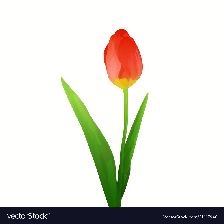

In [94]:
img

In [95]:
y=image.img_to_array(img)
y


array([[[255., 255., 253.],
        [255., 255., 253.],
        [255., 255., 253.],
        ...,
        [255., 255., 253.],
        [255., 255., 253.],
        [255., 255., 253.]],

       [[255., 255., 253.],
        [255., 255., 253.],
        [255., 255., 253.],
        ...,
        [255., 255., 253.],
        [255., 255., 253.],
        [255., 255., 253.]],

       [[255., 255., 253.],
        [255., 255., 253.],
        [255., 255., 253.],
        ...,
        [255., 255., 253.],
        [255., 255., 253.],
        [255., 255., 253.]],

       ...,

       [[ 17.,  18.,  36.],
        [ 17.,  18.,  36.],
        [ 17.,  18.,  36.],
        ...,
        [ 17.,  18.,  36.],
        [ 17.,  18.,  36.],
        [ 17.,  18.,  36.]],

       [[ 17.,  18.,  36.],
        [ 17.,  18.,  36.],
        [ 17.,  18.,  36.],
        ...,
        [ 17.,  18.,  36.],
        [ 17.,  18.,  36.],
        [ 17.,  18.,  36.]],

       [[ 17.,  18.,  36.],
        [ 17.,  18.,  36.],
        [ 17.,  

In [96]:
y.shape

(224, 224, 3)

In [97]:
y=np.expand_dims(y,axis=0)
y.shape

(1, 224, 224, 3)

In [98]:
imgy=preprocess_input(y)
imgy.shape

(1, 224, 224, 3)

In [99]:
imgy=imgy/255


In [100]:
preds= model.predict(imgy)
preds



array([[5.2428880e-04, 3.6089658e-04, 2.8043183e-05, 1.0579923e-06,
        9.9908566e-01]], dtype=float32)

In [101]:
a=np.argmax(preds, axis=1)
a

array([4])

In [102]:
if(a==0):
    print("Daisy")
elif(a==1):
    print("Dandelion")
elif(a==2):
    print("Rose")
elif(a==3):
    print("Sunflower")
else:
    print("Tulip")

Tulip
